In [1]:
import numpy as np
import nltk
import word2vec
import transformers
import requests
import pandas as pd
import matplotlib.pyplot as plt


datasource_config_file = '../data/datasources.yaml'

# Exemplo Simples com Word2Vec

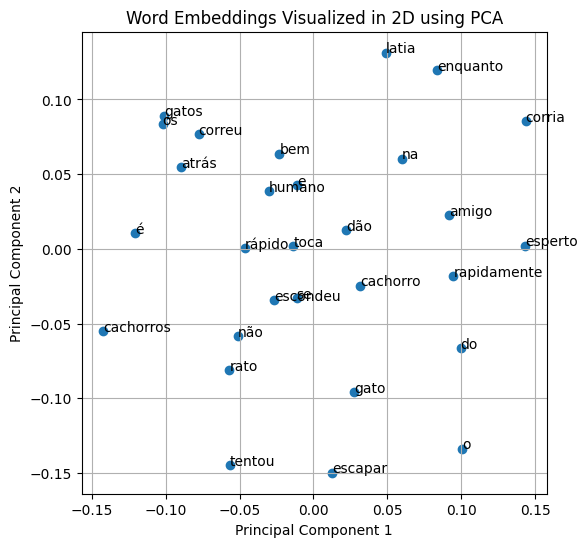

In [2]:
# Import necessary libraries
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example sentences (corpus)
corpus = [
    ['gato', 'correu', 'rapidamente', 'atrás', 'do', 'rato'],
    ['o', 'gato', 'é', 'rápido', 'e', 'esperto'],
    ['o', 'rato', 'se', 'escondeu', 'na', 'toca'],
    ['o', 'cachorro', 'latia', 'enquanto', 'corria', 'atrás', 'do', 'gato'],
    ['os', 'gatos', 'e', 'os', 'cachorros', 'não', 'se', 'dão', 'bem'],
    ['o', 'cachorro', 'é', 'amigo', 'do', 'humano'],
    ['o', 'rato', 'tentou', 'escapar', 'do', 'gato']
]

# Train the Word2Vec model
model = Word2Vec(corpus, vector_size=10, window=2, min_count=1, workers=4)

# Get words in the model's vocabulary
words = list(model.wv.index_to_key)

# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]

# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

# Plot the embeddings in 2D
plt.figure(figsize=(6, 6))
plt.scatter(result[:, 0], result[:, 1])

# Annotate each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Corpus Machado de Assis

In [3]:
filepath = '../data/machado/obras_machado_de_assis.csv'

data = pd.read_csv(filepath, index_col=None)
data.head(2)

,arquivo,caminho completo,categoria,autor,paginas,titulo,edicao,publicacao,publicacao ano,publicacao editora,publicacao cidade,edicao ano,edicao editora,edicao cidade,edicao titulo,edicao volume,texto
0,revelacoes.pdf,./pdf/crítica/revelacoes.pdf,crítica,Machado de Assis,5,"Revelações. Poesias de A. E. Zaluar, Garnier e...",Texto-Fonte: Crítica Literária de Machado de A...,Publicado originalmente no Diário do Rio de Ja...,1863,Diário do Rio de Janeiro,Rio de Janeiro,1938,W. M. Jackson,Rio de Janeiro,Crítica Literária de Machado de Assis,NaN,"Revelações. Poesias de A. E. Zaluar, Garnier e..."
1,magalhaes.pdf,./pdf/crítica/magalhaes.pdf,crítica,Machado de Assis,4,Magalhães de Azeredo: Horas sagradas; Mário de...,Texto-Fonte: Obra Completa de Machado de Assis...,"Publicado na Gazeta de Notícias, 07/12/1902.",1902,Gazeta de Notícias,Rio de Janeiro,1994,Nova Aguilar,Rio de Janeiro,Obra Completa de Machado de Assis,III,Magalhães de Azeredo: Horas sagradas; Mário de...


## Quantidade de Obras por Categoria

<Axes: title={'center': 'Distribuição de Obras por Categoria'}, xlabel='Total Obras', ylabel='categoria'>

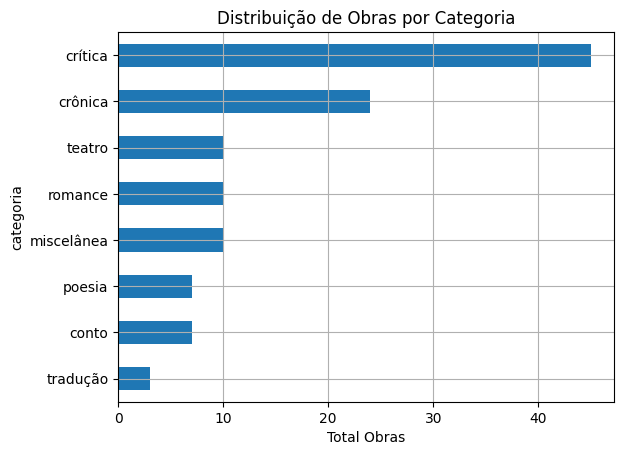

In [4]:
(data.groupby('categoria')
    .arquivo.nunique()
    .sort_values()
    .plot.barh(
        xlabel='Total Obras',
        grid=1,
        title='Distribuição de Obras por Categoria'
    )
)

## Pré-processamento do Corpus para montar o Vocabulário

In [5]:
category_name = 'romance'

# SELECAO DE OBRAS DA CATEGORIA
corpus = data[data.categoria == category_name].texto.tolist()
obras = data[data.categoria == category_name].titulo.tolist()
print('Corpus com', len(corpus), 'obras')

# PROCESSO SEPARACAO DE PALAVRAS
# words = nltk.tokenize.word_tokenize(obras[1])
# words = [nltk.tokenize.word_tokenize(o) for o in corpus] # por obra
# words = [nltk.tokenize.wordpunct_tokenize(o) for o in corpus] # por obra
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

# DOWNLOAD DOS ARQUIVOS COM STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
pt_stopwords = stopwords.words('portuguese')
print('Total de stopwords', len(pt_stopwords))
corpus = [[w for w in o if w not in pt_stopwords] for o in corpus]
corpus[0][:20]

Corpus com 10 obras


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ciodaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de stopwords 207


['Memórias',
 'Póstumas',
 'Brás',
 'Cubas',
 'Ao',
 'verme',
 'primeiro',
 'roeu',
 'frias',
 'carnes',
 'cadáver',
 'dedico',
 'saudosa',
 'lembrança',
 'Memórias',
 'Póstumas',
 'Prólogo',
 'terceira',
 'edição',
 'A']

## Word2Vec

In [6]:
model = gensim.models.Word2Vec(
    sentences=corpus,
    vector_size=100,
    alpha=0.025,
    window=25,
    min_count=10,
    seed=1,
    workers=3,
    sg=0,
)

# Train the Word2Vec model
# model = Word2Vec(corpus, vector_size=20, window=10, min_count=5, workers=4)
# Get words in the model's vocabulary
words = list(model.wv.index_to_key)
# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]
# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

In [7]:
def strip_score(result):
    return [w for w, s in result]
# Lista as palavras mais próximas
def closest_words(word, model, num=5):
    word_score_pair = model.wv.most_similar(word, topn=num)
    return strip_score(word_score_pair)

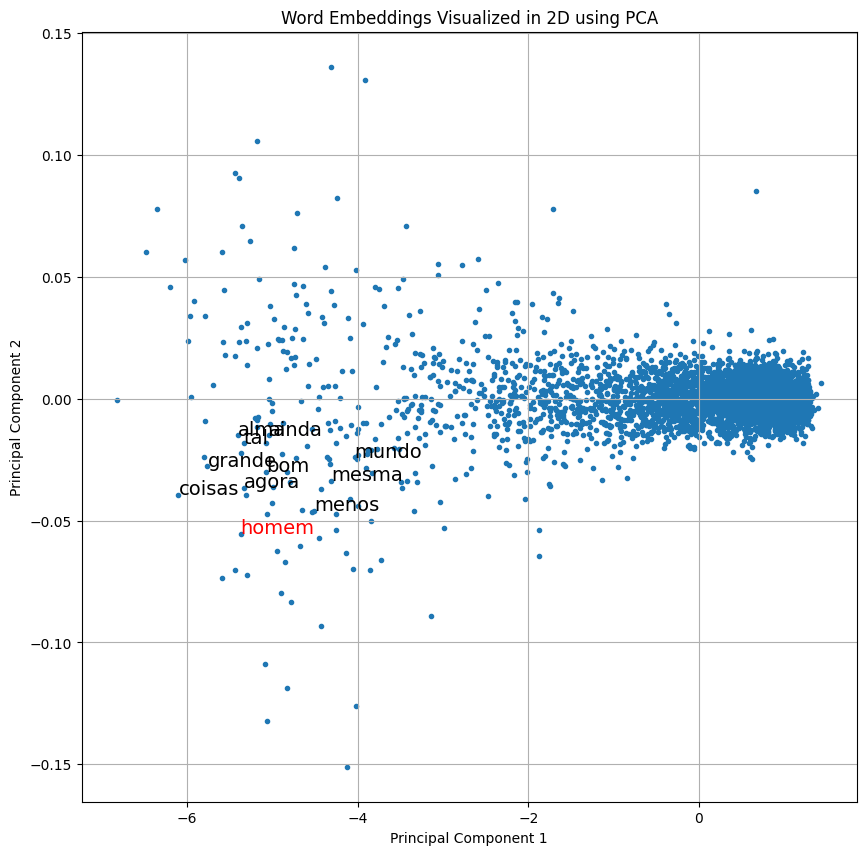

In [8]:
keyword = 'homem' #, 'Cubas', 'Brás', 'Capitu','Bentinho']


# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.')
# Annotate each point with the corresponding word
annotate_words = closest_words(keyword, model, num=10)
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=14, c='k')
xpos = pca.transform([model.wv[keyword]])
plt.annotate(keyword, xy=xpos[0], c='red', size=14)
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Corpus Brasileiro

In [9]:
import glob

filepaths = glob.glob('../data/Brazilian_Portugese_Corpus/*.txt')
corpus = [' '.join(open(f, encoding='latin-1').readlines()) for f in filepaths]

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

# DOWNLOAD DOS ARQUIVOS COM STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
pt_stopwords = stopwords.words('portuguese')
print('Total de stopwords', len(pt_stopwords))
corpus = [[w for w in o if w not in pt_stopwords] for o in corpus]
# UNIDECODE
from unidecode import unidecode
corpus = [unidecode(' '.join(o).lower()) for o in corpus]
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

len(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ciodaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de stopwords 207


81

In [10]:
%%time

model = gensim.models.Word2Vec(
    sentences=corpus,
    vector_size=20,
    # alpha=0.025,
    window=10,
    min_count=10,
    seed=1,
    workers=8,
    sg=0,
    epochs = 100
)

# Train the Word2Vec model
# model = Word2Vec(corpus, vector_size=20, window=10, min_count=5, workers=4)
# Get words in the model's vocabulary
words = list(model.wv.index_to_key)
# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]
# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

CPU times: user 2min 44s, sys: 517 ms, total: 2min 45s
Wall time: 27.3 s


In [11]:
len(model.wv.key_to_index)

19629

In [12]:
# model.wv.key_to_index
model.wv.index_to_key

['e',
 'o',
 'a',
 'nao',
 'ainda',
 'disse',
 'casa',
 'la',
 'bem',
 'olhos',
 'mas',
 'd',
 'tudo',
 'tao',
 'tempo',
 'homem',
 'entao',
 'que',
 'porque',
 'todos',
 'dia',
 'senhor',
 'vez',
 'sobre',
 'outro',
 'amor',
 'lo',
 'assim',
 'mulher',
 'havia',
 'dois',
 'nada',
 'agora',
 'pois',
 'pouco',
 'onde',
 'noite',
 'vida',
 'sempre',
 'pai',
 'outra',
 'senhora',
 'porem',
 'pode',
 'logo',
 'ia',
 'moca',
 'coracao',
 'coisa',
 'toda',
 'fazer',
 'grande',
 'mim',
 'nunca',
 'ver',
 'duas',
 'todo',
 'vezes',
 'mao',
 'filha',
 'alguma',
 'alma',
 'menos',
 'era',
 'dias',
 'mae',
 'eu',
 'dizer',
 'ter',
 'podia',
 'cabeca',
 'aqui',
 'anos',
 'meio',
 'antes',
 'sim',
 'se',
 'dar',
 'todas',
 'voz',
 'velho',
 'mal',
 'si',
 'porta',
 'ai',
 'fez',
 'deus',
 'por',
 'tres',
 'algum',
 'rua',
 'os',
 'alguns',
 'marido',
 'ali',
 'sei',
 'horas',
 'bom',
 'primeiro',
 'maos',
 'outros',
 'amigo',
 'palavras',
 'melhor',
 'tanto',
 'lado',
 'vai',
 'talvez',
 'respondeu

In [13]:
model.wv['amigo']

array([-1.3543965 ,  2.49554   ,  1.7414643 , -4.405164  , -2.374378  ,
        1.5638243 ,  2.638497  , -4.0936255 , -1.0785028 ,  1.0294646 ,
        1.3052089 ,  3.7814777 , -5.773592  ,  0.49214223,  0.26725486,
       -0.26093584,  3.69695   ,  0.32411632,  0.6470765 ,  0.16823293],
      dtype=float32)

In [14]:
model.wv.most_similar(positive=['vinho'], topn=10)

[('aguardente', 0.8647387623786926),
 ('champanha', 0.835534393787384),
 ('regalada', 0.8073676824569702),
 ('gole', 0.799209475517273),
 ('ananas', 0.7619125247001648),
 ('ovos', 0.7557634711265564),
 ('botija', 0.7533196210861206),
 ('garrafas', 0.7519161701202393),
 ('garrafa', 0.7441085577011108),
 ('curtido', 0.7435770034790039)]

In [15]:
model.wv.most_similar(positive=['amigo'], topn=10)

[('sogro', 0.8028638958930969),
 ('tio', 0.7583131194114685),
 ('seabra', 0.7187299728393555),
 ('irmao', 0.7042965292930603),
 ('anselmo', 0.6995179653167725),
 ('andre', 0.6989408135414124),
 ('senhor', 0.6913787126541138),
 ('major', 0.6879306435585022),
 ('pedes', 0.6877106428146362),
 ('recebo', 0.6836262941360474)]

In [16]:
model.wv.most_similar(positive=['noivo', 'mulher'], negative = ['homem'] ,topn=10)

[('noiva', 0.7872740626335144),
 ('irma', 0.754537045955658),
 ('viuvez', 0.7530264258384705),
 ('sobrinha', 0.7368646264076233),
 ('casada', 0.7326229810714722),
 ('fatigada', 0.7273235321044922),
 ('julieta', 0.720532238483429),
 ('bruxa', 0.7140328288078308),
 ('viuvinha', 0.7051794528961182),
 ('entendida', 0.6990033388137817)]

In [17]:
model.wv.most_similar(positive=['brasil'] ,topn=10)

[('capital', 0.8257726430892944),
 ('norte', 0.8191828727722168),
 ('descobertas', 0.8056128025054932),
 ('colonia', 0.7918989658355713),
 ('fundou', 0.7852597832679749),
 ('imperial', 0.771300733089447),
 ('reino', 0.7704440951347351),
 ('provincias', 0.7657479047775269),
 ('brasileiros', 0.763505220413208),
 ('tradicoes', 0.7592082023620605)]

In [18]:
model.wv.similarity('capitu','bentinho')

0.60183036

In [19]:
model.wv.most_similar(positive=['pai', 'mae'], negative=['filho'], topn=10)

[('gravida', 0.7460490465164185),
 ('irma', 0.7323063611984253),
 ('filha', 0.6999140381813049),
 ('adotiva', 0.6971958875656128),
 ('lhas', 0.6945497989654541),
 ('saudades', 0.693648099899292),
 ('lagrimas', 0.6922107934951782),
 ('maezinha', 0.6847760677337646),
 ('joaozinho', 0.6759294271469116),
 ('desgosto', 0.6757584810256958)]

# Plot dos Embeddings e Determinardos Termos

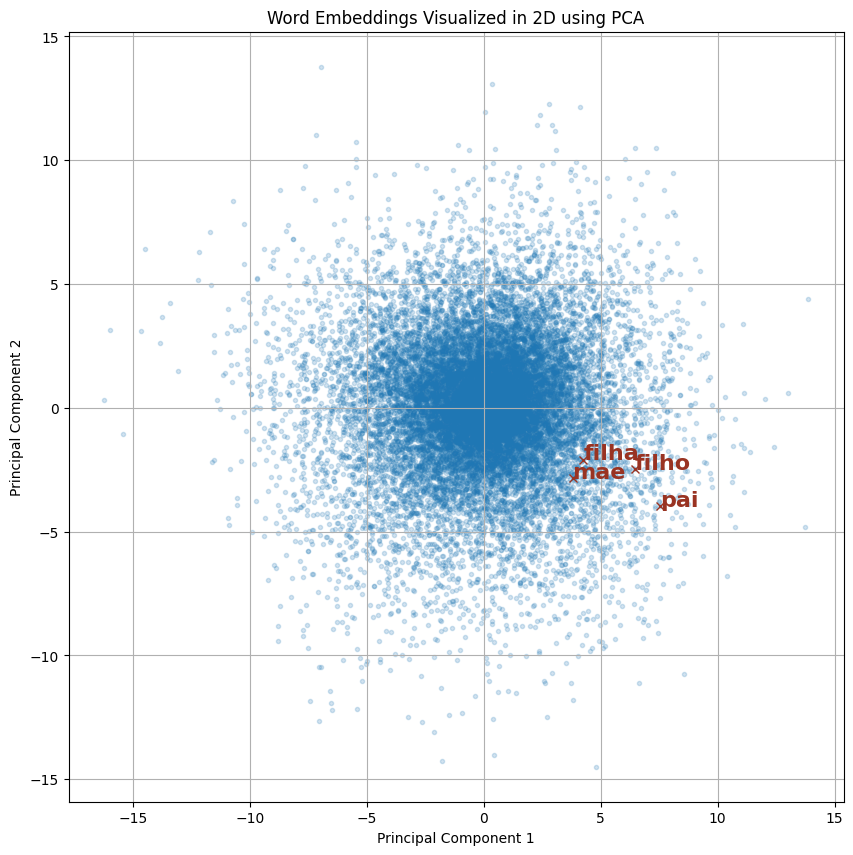

In [20]:
annotate_words = ['pai', 'mae','filho', 'filha'] #, 'Cubas', 'Brás', 'Capitu','Bentinho']

# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.', alpha=0.2)
# Annotate each point with the corresponding word
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=16, c='#993322', weight='bold')
    plt.plot(xpos[0][0], xpos[0][1], 'x', c='#993322')
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Plot da Keyword e Termos Similares

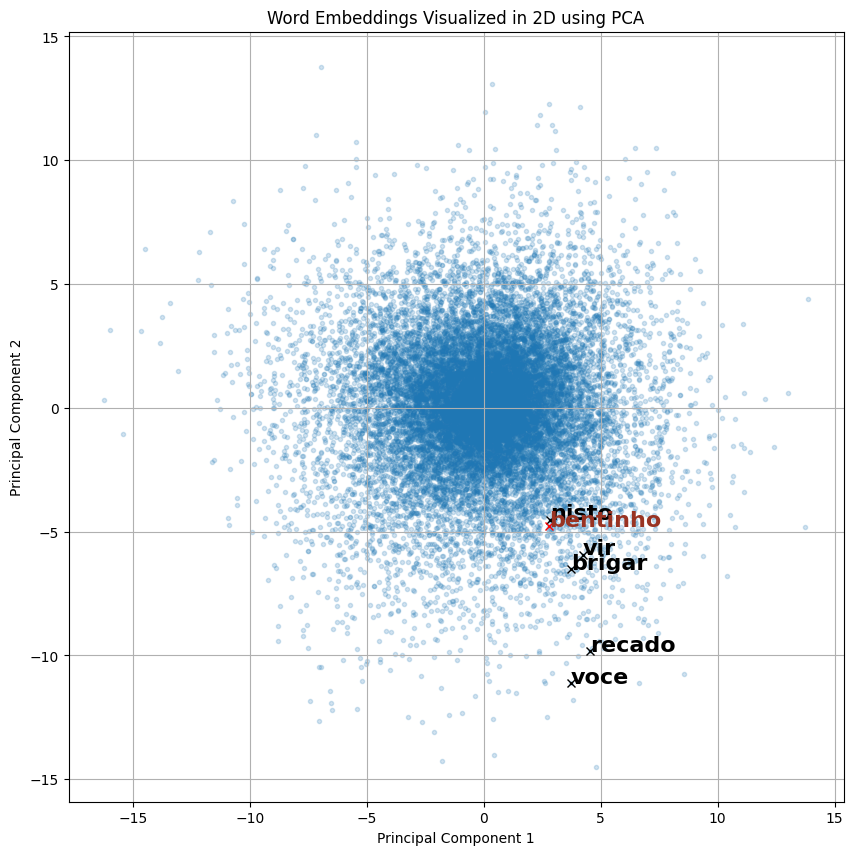

In [21]:
keyword = 'bentinho' #, 'Cubas', 'Brás', 'Capitu','Bentinho']

# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.', alpha=0.2)
# Annotate each point with the corresponding word
annotate_words = closest_words(keyword, model, num=5)
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=16, c='k', weight='bold')
    plt.plot(xpos[0][0], xpos[0][1], 'kx')
xpos = pca.transform([model.wv[keyword]])
plt.annotate(keyword, xy=xpos[0], size=16, c='#993322', weight='bold')
plt.plot(xpos[0][0], xpos[0][1], 'rx')
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Similaridade de Sentenças 

In [49]:
import gensim.downloader as api
from scipy.spatial import distance
model = api.load("glove-wiki-gigaword-50")


In [61]:

# Definir as frases
s0 = "Peter Parker was bit by a spider, thus becaming Spider-man"
# s1 = "Wendy and brothers fled with Pan to the Neverland"
s1 = "Higgs is the scientist that proposed the Higgs Field"

# Função para calcular a média dos vetores das palavras de uma sentença
def sentence_to_vec(sentence, model):
    words = sentence.lower().split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return None
    return sum(word_vectors) / len(word_vectors)

# Converter frases para vetores
vec_s0 = sentence_to_vec(s0, model)
vec_s1 = sentence_to_vec(s1, model)

print('Similaridade por distência Euclideana', 1/distance.euclidean(vec_s0, vec_s1))

Similaridade por distência Euclideana 0.46594452351571763


# Embeddings

In [23]:
import glob
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

model_name = 'neuralmind/bert-base-portuguese-cased'
llm_model_dir = '../data/bertimbau/'


embedding_model = SentenceTransformer(model_name, cache_folder=llm_model_dir, device='cpu')

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


In [24]:
filepaths = glob.glob('../data/Brazilian_Portugese_Corpus/*.txt')
corpus = [' '.join(open(f, encoding='latin-1').readlines()) for f in filepaths]
names =  [f.replace('../data/Brazilian_Portugese_Corpus/','').replace('.txt','') for f in filepaths]
meta = pd.read_csv('../data/guideToDocuments.csv')
authors = [meta[meta.Work.str.replace(",", '').str.replace("'",'') == f"{x}.txt"].Author.tolist()[0] for x in names]

In [25]:
%%time

embeddings = embedding_model.encode(corpus, show_progress_bar=True)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2min 13s, sys: 10.7 s, total: 2min 24s
Wall time: 35.4 s


In [27]:
from umap import UMAP

umap_model = UMAP(
    n_neighbors=5, 
    n_components=2, 
    min_dist=0.0,
    metric='cosine',
    low_memory=True,
    random_state=42
)
Xumap = umap_model.fit_transform(embeddings)

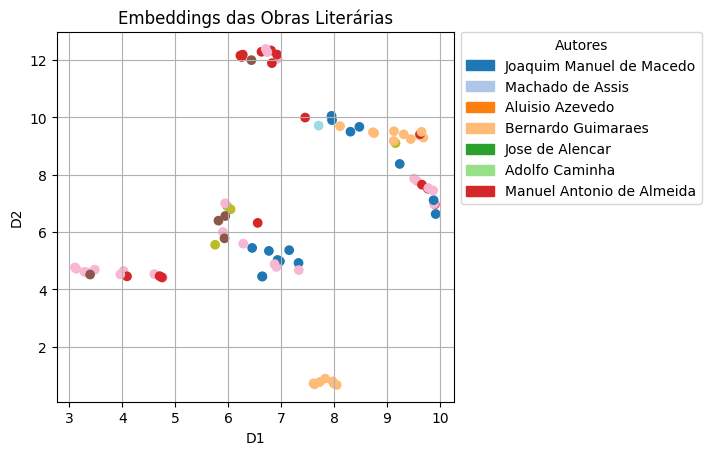

In [28]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches

levels, categories = pd.factorize(authors)
colors = [plt.cm.tab20(i) for i in levels] # using the "tab20" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab20(i), label=c) for i, c in enumerate(categories)]
plt.scatter(Xumap[:,0], Xumap[:,1], c=pd.factorize(authors)[0], cmap='tab20')
plt.gca().set(xlabel='D1', ylabel='D2', title='Embeddings das Obras Literárias')

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.gca().legend(handles=handles,  title='Autores', loc='center left', bbox_to_anchor=(1, 0.767))
plt.grid(1)
    

    

## Exemplos de Embeddings 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

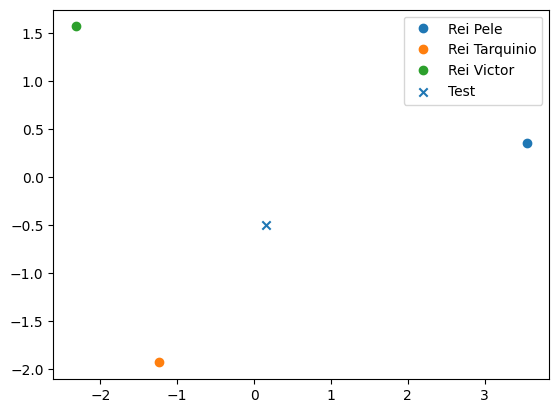

In [29]:
example_corpus = [
    'o rei do futebol é o pelé, que nunca jogou para o roma, da italia',
    'o ultimo rei de roma foi tarquinio, o tirano, antes da unificacao da italia',
    'a italia moderna foi unificada com lideranca do rei Victor Manuel',
]
example_label=['Rei Pele', 'Rei Tarquinio', 'Rei Victor']
embeddings = embedding_model.encode(example_corpus, show_progress_bar=True)

pca_model = PCA(n_components=2).fit(embeddings)
Xpca = pca_model.transform(embeddings)
# plt.scatter(Xpca[:,0], Xpca[:,1])
for i, lab in enumerate(example_label):
    plt.plot(Xpca[i,0], Xpca[i,1], 'o', label=example_label[i])



# frase similar de teste
test_example = ['o rei mais tirano que roma ja teve']
embeddings = embedding_model.encode(test_example , show_progress_bar=True)
Xpca = pca_model.transform(embeddings)
plt.scatter(Xpca[:,0], Xpca[:,1], marker='x', label='Test')

plt.legend(loc='best')

    

# Embeddings Manuais



In [57]:
import numpy as np
from scipy.spatial.distance import euclidean

# Dicionário de embeddings para personagens da Marvel
marvel_embeddings = {
    'Homem de Ferro': [0.9, 0.1, 0.7, 0.6, 0.9],
    'Thor':           [0.1, 0.9, 1.0, 1.0, 0.5],
    'Capitã Marvel':  [0.9, 0.7, 1.0, 0.9, 0.7],
    'Hulk':           [0.7, 0.2, 0.0, 1.0, 0.3],
    'Viúva Negra':    [1.0, 0.0, 0.0, 0.5, 0.7],
    'Doutor Estranho':[0.6, 0.7, 0.4, 0.5, 0.9],
    'Groot':          [0.1, 0.0, 0.0, 0.7, 0.4],
    'Odin':           [0.0, 1.0, 0.8, 1.0, 0.8]
}

# Dicionário de embeddings para personagens da DC Comics
dc_embeddings = {
    'Superman':         [0.1, 0.9, 1.0, 1.0, 0.7], # Voar, Força Bruta
    'Batman':           [1.0, 0.0, 0.0, 0.7, 1.0], # Intelecto elevado, Força moderada
    'Mulher-Maravilha': [0.3, 0.7, 0.6, 0.9, 0.7], # Semideusa, Voar
    'Flash':            [1.0, 0.0, 0.0, 0.6, 0.6], # Humano, Velocidade extrema, Inteligência
    'Aquaman':          [0.5, 0.7, 0.2, 0.7, 0.6], # Meio-humano, Meio-atlante
    'Lanterna Verde':   [0.9, 0.6, 0.8, 0.7, 0.8]  # Tecnologia avançada
}

# Definir os nomes das colunas para o DataFrame
columns = ['Humano', 'Deidade', 'Voar', 'Força Bruta', 'Intelecto']
# Criar DataFrame para os personagens da Marvel
df_marvel = pd.DataFrame.from_dict(marvel_embeddings, orient='index', columns=columns)
# Criar DataFrame para os personagens da DC Comics
df_dc = pd.DataFrame.from_dict(dc_embeddings, orient='index', columns=columns)

# Função para calcular a distância euclidiana
def calcular_distancia(personagem_ref, dicionario_personagens):
    distancias = {}
    for personagem, embedding in dicionario_personagens.items():
        dist = euclidean(personagem_ref, embedding)
        distancias[personagem] = dist
    return sorted(distancias.items(), key=lambda x: x[1])

# Comparar personagens da Marvel com outros personagens da Marvel e da DC
def comparar_personagem(personagem, marvel_embeddings, dc_embeddings):
    # Calcular a distância para outros personagens da Marvel
    referencia = marvel_embeddings[personagem]
    print(f"\n--- Comparando com {personagem} ---\n")

    print("Personagens mais próximos (Marvel):")
    distancias_marvel = calcular_distancia(referencia, marvel_embeddings)
    for i, (personagem, dist) in enumerate(distancias_marvel[1:4]):  # Ignora o próprio personagem
        print(f"{i+1}. {personagem} - Distância: {dist:.3f}")

    print("\nPersonagens mais próximos (DC):")
    distancias_dc = calcular_distancia(referencia, dc_embeddings)
    for i, (personagem, dist) in enumerate(distancias_dc[:3]):
        print(f"{i+1}. {personagem} - Distância: {dist:.3f}")

# Comparar os personagens Homem de Ferro, Thor e Hulk com Marvel e DC
# comparar_personagem('Homem de Ferro', marvel_embeddings, dc_embeddings)
# comparar_personagem('Thor', marvel_embeddings, dc_embeddings)
comparar_personagem('Hulk', marvel_embeddings, dc_embeddings)



--- Comparando com Hulk ---

Personagens mais próximos (Marvel):
1. Groot - Distância: 0.707
2. Viúva Negra - Distância: 0.735
3. Doutor Estranho - Distância: 1.015

Personagens mais próximos (DC):
1. Flash - Distância: 0.616
2. Aquaman - Distância: 0.714
3. Batman - Distância: 0.843


In [45]:
df_marvel

,Humano,Deidade,Voar,Força Bruta,Intelecto
Homem de Ferro,0.9,0.1,0.7,0.6,0.9
Thor,0.1,1.0,1.0,1.0,0.6
Capitã Marvel,0.3,0.9,1.0,0.9,0.7
Hulk,0.2,0.1,0.0,1.0,0.4
Viúva Negra,1.0,0.0,0.0,0.5,0.8
Doutor Estranho,0.6,0.7,0.4,0.5,0.9
Groot,0.1,0.0,0.0,0.7,0.4
Odin,0.0,1.0,0.8,1.0,0.8


In [46]:
df_dc

,Humano,Deidade,Voar,Força Bruta,Intelecto
Superman,0.1,0.9,1.0,1.0,0.8
Batman,1.0,0.0,0.0,0.7,1.0
Mulher-Maravilha,0.2,0.9,0.9,1.0,0.7
Flash,1.0,0.0,0.0,0.6,0.8
Aquaman,0.5,0.7,0.4,0.8,0.6
Lanterna Verde,0.9,0.1,0.8,0.7,0.8
